In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, proximate_fp, calc_jacobian_at
from tools_lnd import make_dendro, gen_trials_from_model_dir, gen_X_from_model_dir, get_T_inds
from sklearn.decomposition import PCA

In [21]:
net = 'stepnet'
model_n = 0
from tools_lnd import name_best_ckpt,get_model_params
p = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/'
transfer_model_dir = '3_tasks/256_n_rnn/l2_w4_h5_fdgo_fdanti_delaygo/0_best/'
# transfer_model_dir = '4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/'
transfer_model_dir = 'l2w0001/0/'
transfer_model_dir = '14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0'
m = os.path.join(p,transfer_model_dir)
w_in, b_in, w_out, b_out = get_model_params(m)

model = FixedPoint_Model(m)
with tf.Session() as sess:
    model.restore()
    hp = model.hp
task_list = hp['rule_trains']

# figpath = os.path.join(p,'code','overleaf','multitask-nets','v1_figs','transfer_')
# if not os.path.exists(figpath):
#     os.makedirs(figpath)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn

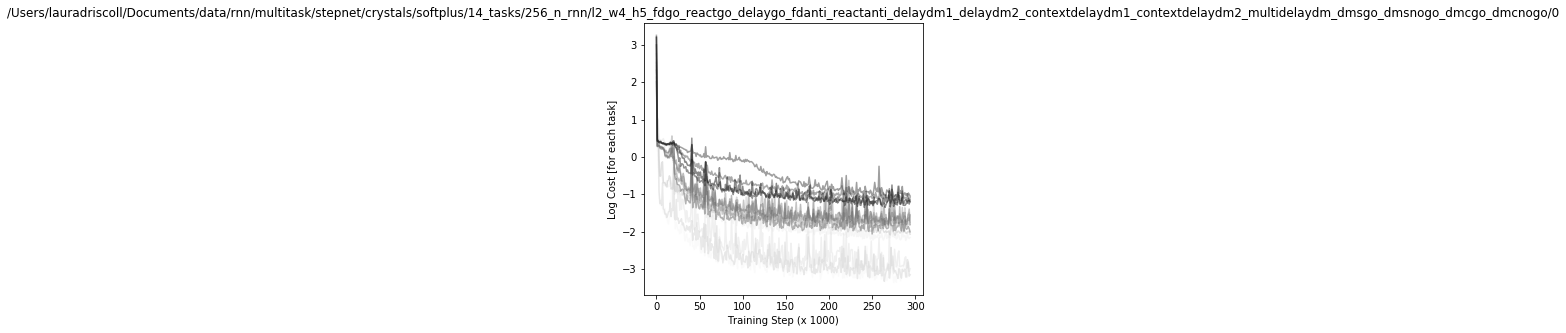

In [22]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

task_list = hp['rule_trains']

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
#     plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [23]:
from collections import OrderedDict
def make_h_all(m,mode = 'test',rules = []):
    model = Model(m, sigma_rec=0)
    with tf.Session() as sess:
        model.restore()

        h_all_byrule = OrderedDict()
        h_all_byepoch = OrderedDict()

        hp = model.hp
        n_hidden = hp['n_rnn']
        
        if len(rules)==0:
            rules = hp['rules']

        for rule in rules:
            trial = generate_trials(rule, hp, mode = mode, noise_on=False, batch_size = 100)
            feed_dict = tools.gen_feed_dict(model, trial, hp)
            h = sess.run(model.h, feed_dict=feed_dict)

            for e_name, e_time in trial.epochs.items():
                # if 'fix' not in e_name:  # Ignore fixation period
                h_all_byepoch[(rule, e_name)] = h[e_time[0]:e_time[1],:,:]
                
            h_all_byrule[rule] = h
                
    return h_all_byepoch, h_all_byrule

In [24]:
_, h_all_byrule = make_h_all(m,mode = 'test',rules = ['fdgo','delaygo', 'fdanti', 'delayanti'])

rules = ['delaygo','fdgo', 'fdanti', 'delayanti']
rule = rules[0]
X_rule = h_all_byrule[rule]
X_use = np.reshape(X_rule[:],(-1,hp['n_rnn']))
for rule in rules[1:]:
    X_rule = h_all_byrule[rule]
    X_use = np.concatenate((X_use,np.reshape(X_rule[:],(-1,hp['n_rnn']))),axis = 0)

from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
h_all_pca = pca.fit_transform(X_use)

Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


In [25]:
from sklearn import linear_model
from numpy import linalg as LA
from tools_lnd import get_D, make_h_trial_rule, get_model_params
dims = 'tdr'
tasks = ['fdgo', 'delaygo', 'fdanti']#hp['rule_trains']
h, trial, _ = make_h_trial_rule(m,task_set = tasks)
epoch = 'stim1'

ind = -1
stim_angle = []
target_angle = []
r = []

for ri in range(len(tasks)):
    rule = tasks[ri]
    T_inds = get_T_inds(trial[rule],epoch)
    T_use = T_inds[ind]
    inds_use = np.min(trial[rule].stim_strength,axis=1)>.5
    r_temp = h[rule][T_use,inds_use,:].T
    stim1_locs = np.min(trial[rule].stim_locs[:,[0,2]],axis=1)
    stim_angle_temp = stim1_locs[inds_use]
    target_angle_temp = trial[rule].y_loc[-1,inds_use]
    
    if len(stim_angle)==0:
        stim_angle = stim_angle_temp
        target_angle = target_angle_temp
        r = r_temp
    else: 
        stim_angle = np.concatenate((stim_angle,stim_angle_temp))
        target_angle = np.concatenate((target_angle,target_angle_temp))
        r = np.concatenate((r,r_temp),axis = 1)
        
y1 = np.expand_dims(np.sin(stim_angle),axis = 1)
y2 = np.expand_dims(np.cos(stim_angle),axis = 1)
stim_y = np.concatenate((y1,y2),axis=1)

lm = linear_model.LinearRegression()
model = lm.fit(stim_y,r.T)
Beta = model.coef_
B_stim,_ = LA.qr(Beta)

y1 = np.expand_dims(np.sin(target_angle),axis = 1)
y2 = np.expand_dims(np.cos(target_angle),axis = 1)
target_y = np.concatenate((y1,y2),axis=1)

lm = linear_model.LinearRegression()
model = lm.fit(target_y,r.T)
Beta = model.coef_
B_target,_ = LA.qr(Beta)
            

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


In [26]:
def get_var(h_rule,inds):

    h = h_rule[inds[-1],:,:]
    hD = np.dot(h,D.T)
    var_trial = np.var(hD,axis = 0)

    h = np.mean(h_rule[inds,:,:],axis = 1)
    hD = np.dot(h,D.T)
    var_time = np.var(hD,axis = 0)

    return var_trial, var_time

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float

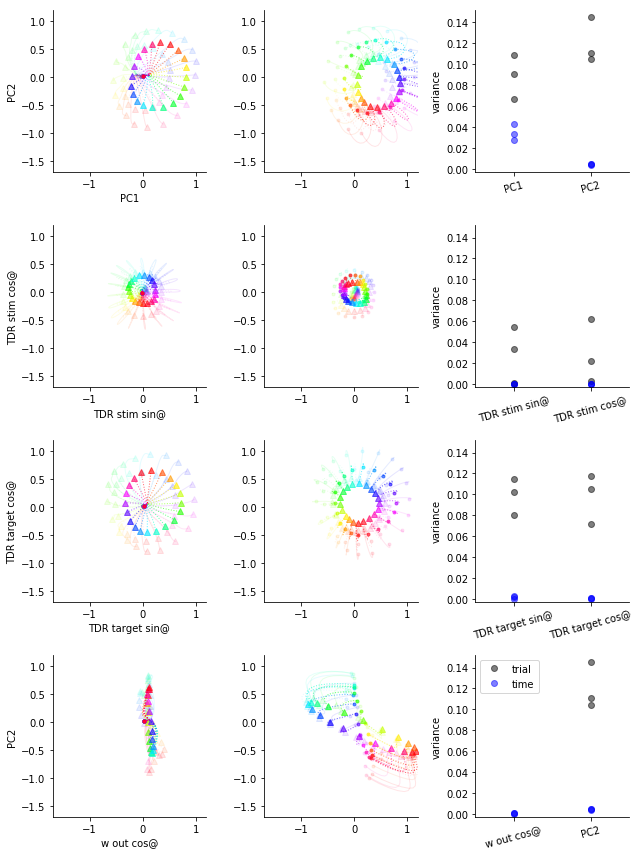

In [15]:
from tools_lnd import plot_N
rules = ['fdgo', 'delaygo', 'fdanti'] #['fdgo', 'delaygo', 'fdanti', 'delayanti']
linestyles = [':','-',':','-']
color_list = [.1,.1,.6,.6]
trial_set = range(0,80,4)
n_steps = -25

_, _, w_out, _  = get_model_params(m)

D_inds = {}
D_inds[1] = B_stim.T
D_inds[2] = B_target.T
D_inds[0] = np.concatenate((pca.components_[[0,],:],-pca.components_[[1,],:]),axis = 0)
D_inds[3] = np.concatenate((w_out[:,[2,]].T,-pca.components_[[1,],:]),axis = 0)

axes_labels = {}
axes_labels[1] = ['TDR stim sin@','TDR stim cos@']
axes_labels[2] = ['TDR target sin@','TDR target cos@']
axes_labels[0] = ['PC1','PC2']
axes_labels[3] = ['w out cos@','PC2']

nr = len(D_inds)
nc = 3
lim = 1.2
lim_neg = -lim-.5

var = {}
var['trial'] = np.zeros((nr,2))
var['time'] = np.zeros((nr,2))

fig = plt.figure(figsize=(3*nc,3*nr),tight_layout=True,facecolor='white')
for ri in range(len(rules)):
    rule = rules[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    X = np.transpose(h_all_byrule[rule][:,trial_set,:],(1, 0, 2))
    
    inds = {}
    inds['all'] = range(0,np.shape(X)[1])
    inds['stim'] = range(0,trial.epochs['go1'][0])
    inds['go'] = range(trial.epochs['go1'][0],np.shape(X)[1])
    
    for sp in range(nr):
        
        D = D_inds[sp]
        ax1 = plt.subplot(nr,nc,nc*sp+1)
        X_subselect = X[:,inds['stim'],:]
        clist = np.min(trial.stim_locs[trial_set,:],axis = 1)/(2*np.pi)
        plot_N(X_subselect, D, clist,linestyle = linestyles[ri],alpha = color_list[ri])
        plt.xlabel(axes_labels[sp][0])
        plt.ylabel(axes_labels[sp][1])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        plt.xlim((lim_neg,lim))
        plt.ylim((lim_neg,lim))
        
#         var_trial, var_time = get_var(h_all_byrule[rule],inds['stim'])
#         var['trial'][sp,:] = var_trial
#         var['time'][sp,:] = var_time
        
#         ax3 = plt.subplot(nr,nc,nc*sp+2)
#         plt.plot([0,1],var_trial,'ok',alpha = .5,label = 'trial')
#         plt.plot([0,1],var_time,'ob',alpha = .5,label = 'time')
        
#         if sp==(nr-1):
#             plt.legend(['trial','time'])
#         if sp ==0:
#             stim_ylim = ax3.get_ylim()
#         else:
#             plt.ylim((stim_ylim))
                
#         plt.xlim((-.5,1.5))
#         plt.ylabel('variance')
#         plt.xticks([0,1],axes_labels[sp],rotation = 15)
        
#         ax3.spines['top'].set_visible(False)
#         ax3.spines['right'].set_visible(False)
        
        
        ax2 = plt.subplot(nr,nc,nc*sp+2)
        X_subselect = X[:,inds['go'],:]
        clist = trial.y_loc[-1,trial_set]
        plot_N(X_subselect, D, clist,linestyle = linestyles[ri],alpha = color_list[ri])
        
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        plt.xlim((lim_neg,lim))
        plt.ylim((lim_neg,lim))
        
        var_trial, var_time = get_var(h_all_byrule[rule],inds['all'])
        var['trial'][sp,:] = var_trial
        var['time'][sp,:] = var_time
        
        ax3 = plt.subplot(nr,nc,nc*sp+3)
        plt.plot([0,1],var_trial,'ok',alpha = .5,label = 'trial')
        plt.plot([0,1],var_time,'ob',alpha = .5,label = 'time')
        
        if sp==(nr-1):
            plt.legend(['trial','time'])
        if sp ==0:
            go_ylim = ax3.get_ylim()
        else:
            plt.ylim((go_ylim))
                
        plt.xlim((-.5,1.5))
        plt.ylabel('variance')
        plt.xticks([0,1],axes_labels[sp],rotation = 15)
        
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)

In [29]:
n_components = 3
rule = 'delaygo'
_, h_all_byrule = make_h_all(m,mode = 'test',rules = ['fdgo', 'delaygo', 'fdanti', 'delayanti'])
X_rule = h_all_byrule[rule]
X_use = np.reshape(X_rule[:],(-1,hp['n_rnn']))

pca_rule = PCA(n_components = n_components)
h_all_pca = pca_rule.fit_transform(X_use)

Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/14_tasks/256_n_rnn/l2_w4_h5_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float

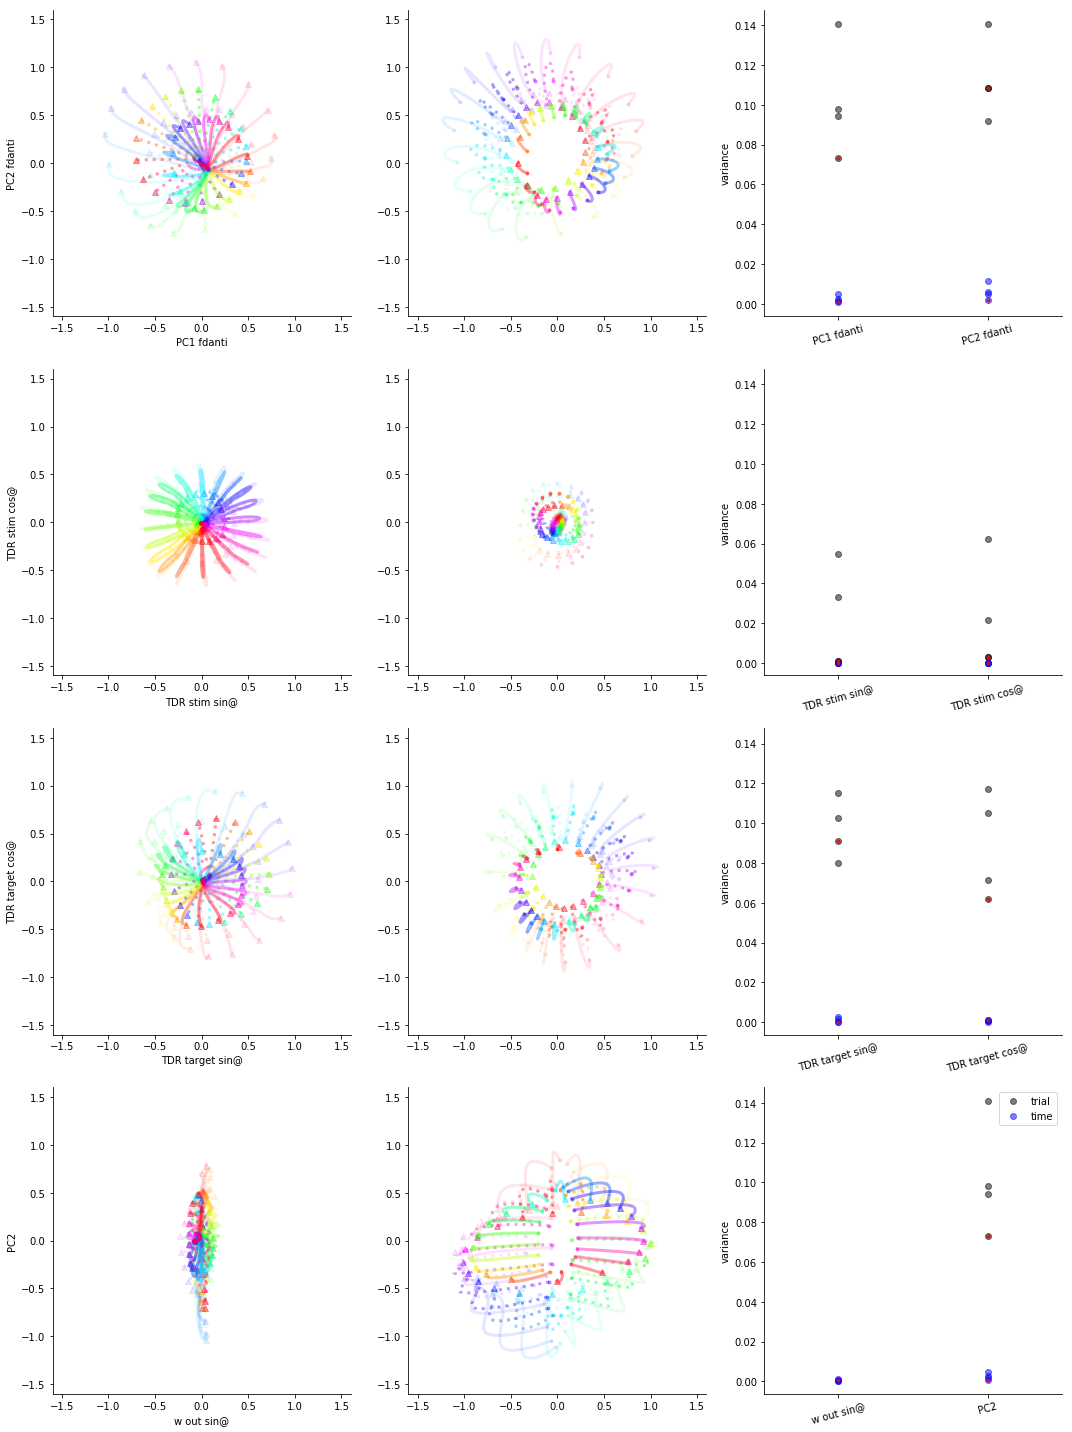

In [32]:
from tools_lnd import plot_N
rules = ['fdgo', 'delaygo', 'fdanti','delayanti']
linestyles = [':','-',':','-']
color_list = [.1,.1,.4,.4]
trial_set = range(0,80,4)
n_steps = -25

w_in, b_in, w_out, b_out  = get_model_params(m)

D_inds = {}
D_inds[1] = B_stim.T
D_inds[2] = B_target.T
D_inds[0] = np.concatenate((-pca_rule.components_[[0,],:],pca_rule.components_[[1,],:]),axis = 0)
D_inds[3] = np.concatenate((w_out[:,[1,]].T,-pca_rule.components_[[0,],:]),axis = 0)

axes_labels = {}
axes_labels[1] = ['TDR stim sin@','TDR stim cos@']
axes_labels[2] = ['TDR target sin@','TDR target cos@']
axes_labels[0] = ['PC1 '+rule,'PC2 '+rule]
axes_labels[3] = ['w out sin@','PC2']

nr = len(D_inds)
nc = 3
lim = 1.6
lim_neg = -lim

var = {}
var['trial'] = np.zeros((nr,2))
var['time'] = np.zeros((nr,2))

fig = plt.figure(figsize=(5*nc,5*nr),tight_layout=True,facecolor='white')
for ri in range(len(rules)):
    rule = rules[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    X = np.transpose(h_all_byrule[rule][:,trial_set,:],(1, 0, 2))
    
    inds = {}
    inds['all'] = range(0,np.shape(X)[1])
    inds['stim'] = range(0,trial.epochs['go1'][0])
    inds['go'] = range(trial.epochs['go1'][0],np.shape(X)[1])
    
    for sp in range(nr):
        
        D = D_inds[sp]
        ax1 = plt.subplot(nr,nc,nc*sp+1)
        X_subselect = X[:,inds['stim'],:]
        clist = np.min(trial.stim_locs[trial_set,:],axis = 1)/(2*np.pi)
        plot_N(X_subselect, D, clist,linestyle = linestyles[ri],alpha = color_list[ri], linewidth = 3)
        plt.xlabel(axes_labels[sp][0])
        plt.ylabel(axes_labels[sp][1])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        plt.xlim((lim_neg,lim))
        plt.ylim((lim_neg,lim))
        
#         var_trial, var_time = get_var(h_all_byrule[rule],inds['stim'])
#         var['trial'][sp,:] = var_trial
#         var['time'][sp,:] = var_time
        
#         ax3 = plt.subplot(nr,nc,nc*sp+2)
#         plt.plot([0,1],var_trial,'ok',alpha = .5,label = 'trial')
#         plt.plot([0,1],var_time,'ob',alpha = .5,label = 'time')
        
#         if sp==(nr-1):
#             plt.legend(['trial','time'])
#         if sp ==0:
#             stim_ylim = ax3.get_ylim()
#         else:
#             plt.ylim((stim_ylim))
                
#         plt.xlim((-.5,1.5))
#         plt.ylabel('variance')
#         plt.xticks([0,1],axes_labels[sp],rotation = 15)
        
#         ax3.spines['top'].set_visible(False)
#         ax3.spines['right'].set_visible(False)
        
        
        ax2 = plt.subplot(nr,nc,nc*sp+2)
        X_subselect = X[:,inds['go'],:]
        clist = trial.y_loc[-1,trial_set]
        plot_N(X_subselect, D, clist,linestyle = linestyles[ri],alpha = color_list[ri], linewidth = 3)
        
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        plt.xlim((lim_neg,lim))
        plt.ylim((lim_neg,lim))
        
        var_trial, var_time = get_var(h_all_byrule[rule],inds['all'])
        var['trial'][sp,:] = var_trial
        var['time'][sp,:] = var_time
        
        ax3 = plt.subplot(nr,nc,nc*sp+3)
        plt.plot([0,1],var_trial,'ok',alpha = .5,label = 'trial')
        plt.plot([0,1],var_time,'ob',alpha = .5,label = 'time')
        
        if rule == 'delayanti':
            plt.plot([0,1],var_trial,'.r',alpha = .8,label = 'trial')
            plt.plot([0,1],var_time,'.r',alpha = .8,label = 'time')
            
        
        if sp==(nr-1):
            plt.legend(['trial','time'])
        if sp ==0:
            go_ylim = ax3.get_ylim()
        else:
            plt.ylim((go_ylim))
                
        plt.xlim((-.5,1.5))
        plt.ylabel('variance')
        plt.xticks([0,1],axes_labels[sp],rotation = 15)
        
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)